In [1]:
import numpy as np
from scipy.stats import norm
import random
import pandas as pd
from tqdm import tqdm  

# Define the number of politicians and the dimensionality of the ideal points
dim_ideal_points = 1
num_politicians = 100
num_bills = 1000
doc_length = 10
vocab_size = 500
num_survey_questions = 100

# Define the parameters of the normal distribution for ideal points
mean_ideal_points = np.zeros(dim_ideal_points)
cov_ideal_points = np.eye(dim_ideal_points)

# Generate ideal points for politicians
ideal_points = np.random.multivariate_normal(mean_ideal_points, cov_ideal_points, num_politicians)

# Function to generate speeches based on ideal points
def generate_speeches(ideal_points, doc_length, vocab_size, progress_bar=False):
    ideal_point_word_matrix = np.random.rand(ideal_points.shape[1], vocab_size)
    
    if progress_bar:
        iterator = tqdm(range(ideal_points.shape[0]))
    else:
        iterator = range(ideal_points.shape[0])
    documents = []
    for i in iterator:
        doc_ideal_points = ideal_points[i]
        doc_words = []
        word_probs = np.dot(doc_ideal_points, ideal_point_word_matrix)
        word_probs = np.exp(word_probs) / np.sum(np.exp(word_probs))
        for _ in range(doc_length):
            word_index = np.random.choice(vocab_size, p=word_probs)
            doc_words.append('word_' + str(word_index))
        doc_words = ' '.join(doc_words)
        documents.append(doc_words)
    return documents

# Function to generate voting behavior based on ideal points
def generate_voting(ideal_points, num_bills, progress_bar=False):
    votes = []
    if progress_bar:
        iterator = tqdm(range(num_bills))
    else:
        iterator = range(num_bills)
    for bill in iterator:
        bill_position = np.random.randn(dim_ideal_points)  # Position of the bill in the ideal point space
        vote_probs = norm.cdf(np.dot(ideal_points, bill_position))  # Probability of voting 'yes'
        votes.append(np.random.binomial(1, vote_probs))
    return np.array(votes).T

# Function to generate survey answers based on ideal points
def generate_survey_answers(ideal_points, num_survey_questions, progress_bar=False):
    survey_answers = []
    if progress_bar:
        iterator = tqdm(range(num_survey_questions))
    else:
        iterator = range(num_survey_questions)
    for survey in iterator:
        categories_per_survey = np.random.randint(2, 6)  # Random number of categories between 2 and 5
        survey_position = np.random.randn(dim_ideal_points, categories_per_survey)  # Position of each category in the ideal point space
        # Calculate the scores for each category
        scores = np.dot(ideal_points, survey_position)
        # Convert scores to probabilities using softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))  # Stability fix for softmax
        answer_probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        # Select the category with the highest probability
        answers = [np.random.choice(categories_per_survey, p=answer_probs[i]) for i in range(ideal_points.shape[0])]
        survey_answers.append(answers)
    return np.array(survey_answers).T

# Generate speeches, voting behavior, and survey answers based on ideal points
speeches = generate_speeches(
    ideal_points,
    doc_length=doc_length,
    vocab_size=vocab_size,
    progress_bar=True
)
voting = generate_voting(
    ideal_points,
    num_bills=num_bills,
    progress_bar=True
)
survey_answers = generate_survey_answers(
    ideal_points,
    num_survey_questions=num_survey_questions,
    progress_bar=True
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 267.38it/s]


In [2]:
import numpy as np
import pandas as pd

# Assuming the following variables are already defined:
# speeches, num_politicians, num_bills, voting, survey_answers, num_survey_questions

# Create initial DataFrame
data = pd.DataFrame({'doc_clean': speeches, 'i': range(1, num_politicians + 1)})
vote_cols = [f'vote_{i+1}' for i in range(num_bills)]
vote_data = pd.DataFrame(voting, columns=vote_cols)
survey_cols = [f'Q_{i+1}' for i in range(num_survey_questions)]
survey_data = pd.DataFrame(survey_answers, columns=survey_cols)
data = pd.concat([data, vote_data, survey_data], axis=1)

data['cov0'] = np.random.rand(num_politicians)
data['cov1'] = np.random.rand(num_politicians)
data['t'] = 1

# Ensure vote columns are of type float
data[vote_cols] = data[vote_cols].astype(float)

# Replace X% of the vote column cells with NaN
num_cells = data[vote_cols].size
num_nan = int(num_cells * 0.3)

# Get the flattened array of vote data
flat_vote_data = data[vote_cols].values.flatten()

# Randomly choose indices to replace with NaN
nan_indices = np.random.choice(num_cells, num_nan, replace=False)

# Replace the selected indices with NaN
flat_vote_data[nan_indices] = np.nan

# Reshape the flat array back to the original DataFrame
data[vote_cols] = flat_vote_data.reshape(data[vote_cols].shape)

#data = data.fillna(0)

# Print the DataFrame
print(data.head())

                                           doc_clean  i  vote_1  vote_2  \
0  word_166 word_475 word_433 word_328 word_12 wo...  1     NaN     NaN   
1  word_168 word_64 word_453 word_101 word_394 wo...  2     NaN     0.0   
2  word_389 word_78 word_468 word_413 word_21 wor...  3     0.0     NaN   
3  word_52 word_181 word_389 word_359 word_323 wo...  4     NaN     1.0   
4  word_349 word_218 word_388 word_1 word_96 word...  5     0.0     NaN   

   vote_3  vote_4  vote_5  vote_6  vote_7  vote_8  ...  Q_94  Q_95  Q_96  \
0     NaN     NaN     0.0     NaN     NaN     NaN  ...     1     0     3   
1     1.0     1.0     1.0     0.0     0.0     0.0  ...     2     0     0   
2     0.0     0.0     0.0     NaN     1.0     0.0  ...     1     0     2   
3     NaN     1.0     0.0     1.0     1.0     1.0  ...     1     1     2   
4     1.0     0.0     1.0     0.0     NaN     NaN  ...     3     0     3   

   Q_97  Q_98  Q_99  Q_100      cov0      cov1  t  
0     3     1     0      2  0.786727  0.

In [3]:
# Create a DataFrame with speeches and voting behavior
#data = pd.DataFrame({'doc_clean': speeches, 'i': range(1, num_politicians + 1)})
#vote_cols = [f'vote_{i+1}' for i in range(num_bills)]
#vote_data = pd.DataFrame(voting, columns=vote_cols)
#survey_cols = [f'Q_{i+1}' for i in range(num_survey_questions)]
#survey_data = pd.DataFrame(survey_answers, columns=survey_cols)
#data = pd.concat([data, vote_data, survey_data], axis=1)

#data['cov0'] = np.random.rand(num_politicians)
#data['cov1'] = np.random.rand(num_politicians)
#data['t'] = 1

# Print the DataFrame
#print(data.head())

In [4]:
import sys
sys.path.append('../IdealPointNN/')
from dataset import IdealPointNNDataset
from ideal_point_model import IdealPointNN

train_data = IdealPointNNDataset(
    data,
    ideology = "~ cov0 + cov1"
)
#train_data.add_modality(
#    modality = 'text'
#)
train_data.add_modality(
    modality = 'vote',
    columns = ['vote_{}'.format(i+1) for i in range(num_bills)]
)
#train_data.add_modality(
#    modality = 'discrete_choice',
#    columns = ['Q_{}'.format(i+1) for i in range(num_survey_questions)]
#)

/home/germain/Documents/neural_ideal_points/neural_ideal_point_models/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
train_data.modalities

['vote']

In [6]:
train_datasets = [train_data]

In [12]:
m = IdealPointNN(
    train_datasets, 
    n_dims=dim_ideal_points,
    update_prior=False,
    log_every_n_epochs = 1,
    dropout = 0,
    w_prior = 1,
    batch_size = 500,
    learning_rate=1e-3,
    patience=3, 
    seed = 10
)


Epoch   1	Mean Training Loss:2.0161023


Epoch   2	Mean Training Loss:3.2990382


Epoch   3	Mean Training Loss:1.8812866


Epoch   4	Mean Training Loss:0.7823620


Epoch   5	Mean Training Loss:1.0590167


Epoch   6	Mean Training Loss:1.3035345


Epoch   7	Mean Training Loss:1.0237286


Early stopping at Epoch 7. Reverting to Epoch 4


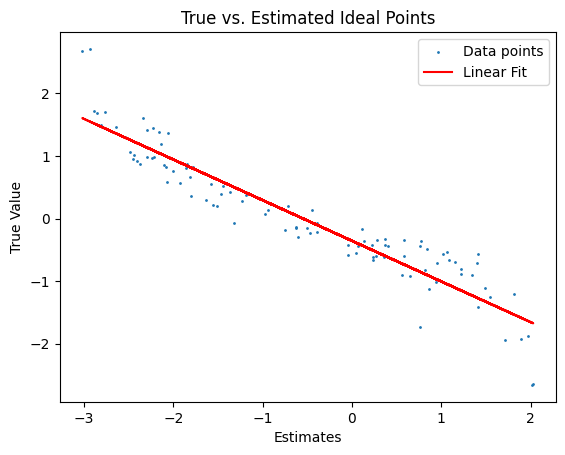

In [13]:
import numpy as np
import matplotlib.pyplot as plt

doc_dims = m.get_ideal_points(train_datasets)

x = doc_dims
y = ideal_points

plt.scatter(x, y, label='Data points', s=1)
coefficients = np.polyfit(x.flatten(), y.flatten(), 1)
fit = np.poly1d(coefficients)
plt.plot(x, fit(x), color='red', label='Linear Fit')
plt.xlabel('Estimates')
plt.ylabel('True Value')
plt.title('True vs. Estimated Ideal Points')
plt.legend()
plt.show()

In [14]:
print(np.corrcoef(x[:,0],y[:,0]))

[[ 1.         -0.93923709]
 [-0.93923709  1.        ]]


In [10]:
import numpy as np
import matplotlib.pyplot as plt

x1 = m.get_ideal_points(train_datasets, modality='text')
x2 = m.get_ideal_points(train_datasets, modality='vote')
x3 = m.get_ideal_points(train_datasets, modality='discrete_choice')

# Plot the first set
plt.scatter(x1, y, label='Text', s=1, color='blue')
coefficients_1 = np.polyfit(x1.flatten(), y.flatten(), 1)
fit_1 = np.poly1d(coefficients_1)
plt.plot(x1, fit_1(x1), color='blue', linestyle='--', label='Linear Fit Text')

# Plot the second set
plt.scatter(x2, y, label='Vote', s=1, color='green')
coefficients_2 = np.polyfit(x2.flatten(), y.flatten(), 1)
fit_2 = np.poly1d(coefficients_2)
plt.plot(x2, fit_2(x2), color='green', linestyle='--', label='Linear Fit Vote')

# Plot the third set
plt.scatter(x3, y, label='Discrete Choice', s=1, color='red')
coefficients_3 = np.polyfit(x3.flatten(), y.flatten(), 1)
fit_3 = np.poly1d(coefficients_3)
plt.plot(x3, fit_3(x3), color='red', linestyle='--', label='Linear Fit Choice')

plt.xlabel('Estimates')
plt.ylabel('True Value')
plt.title('True vs. Estimated Ideal Points')
plt.legend()
plt.show()

KeyError: 'text'

In [ ]:
print(np.corrcoef(x1[:,0],y[:,0]))
print(np.corrcoef(x2[:,0],y[:,0]))
print(np.corrcoef(x3[:,0],y[:,0]))

In [ ]:
print('Estimated lambda: {}'.format(m.prior.lambda_))
print('Estimated sigma: {}'.format(m.prior.sigma))